In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import string
import re
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
recs = pd.read_csv('cleaned_recs.csv')[['Document File Name ', 'Recommendation text']].dropna(0, 'all')
# df = df[['Recommendation text']].dropna().reset_index(drop = True)
file_mapping = pd.read_csv("file_mapping.csv")

In [5]:
merged = pd.merge(recs, file_mapping, left_on="Document File Name ", right_on="original_name", how='inner')

In [6]:
test = merged.loc[(merged.indexed_name == '12.pdf') | (merged.indexed_name == '9.pdf')]
train = merged.loc[~((merged.indexed_name == '12.pdf') | (merged.indexed_name == '9.pdf'))]

In [7]:
train.shape[0], test.shape[0]

(100, 9)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import pickle, os, difflib, random
from sklearn.model_selection import train_test_split

def load_list_from_pickle(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage:
filename = os.path.join('pkl_files', "sentences.pkl")
sentences = load_list_from_pickle(filename)

In [10]:
def retrieve_sentence_index(sentence, sentence_list):
    # Tokenize the sentences
    sentence_tokens = sentence.split()
    sentence_list_tokens = [s.split() for s in sentence_list]
    
    # Calculate the similarity between the sentences
    similarity_scores = [difflib.SequenceMatcher(None, sentence_tokens, s).ratio() for s in sentence_list_tokens]
    
    # Find the index of the most similar sentence
    max_similarity_index = similarity_scores.index(max(similarity_scores))
    
    return max_similarity_index

train_indices = [retrieve_sentence_index(sentence, sentences) for sentence in train.iloc[:, 1]]
test_indices = [retrieve_sentence_index(sentence, sentences) for sentence in test.iloc[:, 1]]

train_recs = [sentences[idx] for idx in set(train_indices)]
test_recs = [sentences[idx] for idx in set(test_indices)]

non_recs = []
while len(non_recs) != 125:
    samp_idx = np.random.choice(len(sentences))
    if (samp_idx not in train_indices + test_indices) and (len(sentences[samp_idx].split()) > 10):
        non_recs.append(sentences[samp_idx])

train_non_recs = non_recs[:110]
test_non_recs = non_recs[110:]

train_texts = train_non_recs + train_recs
test_texts = test_non_recs + test_recs

train_labels = [0] * len(train_non_recs) + [1] * len(train_recs)
test_labels = [0] * len(test_non_recs) + [1] * len(test_recs)

train_combined = list(zip(train_texts, train_labels))
test_combined = list(zip(test_texts, test_labels))

# # Shuffle the combined lists
# random.shuffle(train_combined)
# random.shuffle(test_combined)

texts, labels = zip(*train_combined)
test_texts, test_labels = zip(*test_combined)

# # Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

### Sentence Embeddings

In [11]:
import seaborn as sns
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [12]:
# sentences = train['Recommendation text'].to_numpy()
# sentence_embeddings = sbert_model.encode(sentences)
sentence_embeddings = sbert_model.encode(texts)

In [13]:
sentence_embeddings.shape

(206, 768)

In [14]:
nonrecomm_embeddings = sentence_embeddings[:110]
recomm_embeddings = sentence_embeddings[110:]

### K-Means Clustering

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


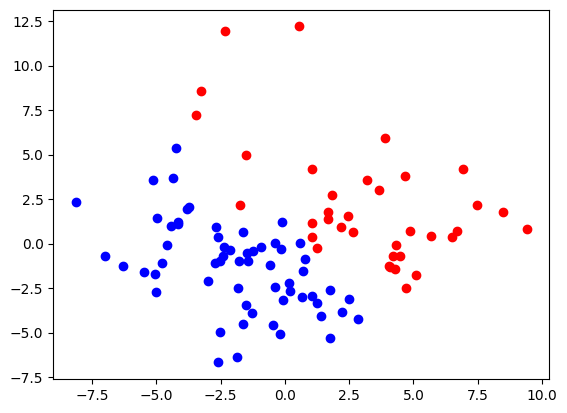

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(recomm_embeddings)

# Use PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(recomm_embeddings)

# Create a scatter plot of the reduced embeddings with different colors for each cluster
colors = ['red', 'blue', 'green', 'yellow', 'black', 'cyan']
for i in range(num_clusters):
    plt.scatter(reduced_embeddings[kmeans.labels_ == i, 0], 
                reduced_embeddings[kmeans.labels_ == i, 1], 
                c=colors[i], label=f'Cluster {i}')

### Cosine Similarity

In [16]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

matrix = np.identity(recomm_embeddings.shape[0])
for i in range(matrix.shape[0]):
  for j in range(i,matrix.shape[0]):
    matrix[i][j] = cosine(recomm_embeddings[i],recomm_embeddings[j])
    matrix[j][i] = matrix[i][j]

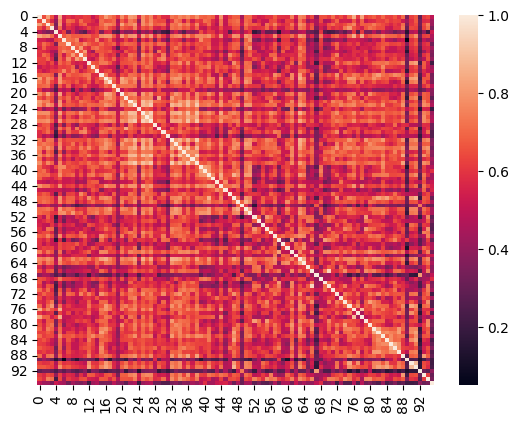

In [17]:
ax = sns.heatmap(matrix)

In [18]:
cluster1, cluster2 = kmeans.cluster_centers_

In [19]:
recomm_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in recomm_embeddings]
nonrecomm_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in nonrecomm_embeddings]

(array([ 8.,  1.,  5., 12.,  8., 16., 22., 17., 14.,  7.]),
 array([0.29478174, 0.35388339, 0.41298503, 0.47208664, 0.53118831,
        0.59028995, 0.64939153, 0.70849317, 0.76759481, 0.82669646,
        0.8857981 ]),
 <BarContainer object of 10 artists>)

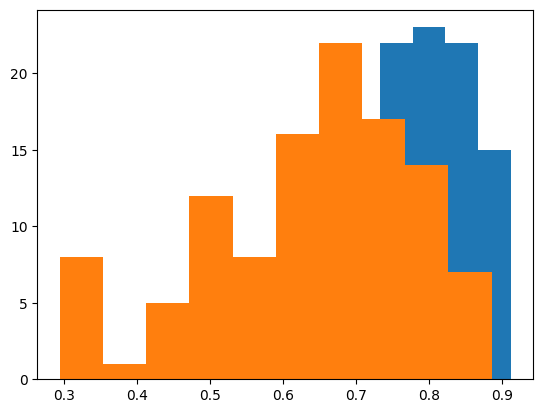

In [20]:
plt.hist(recomm_cosines)
plt.hist(nonrecomm_cosines)

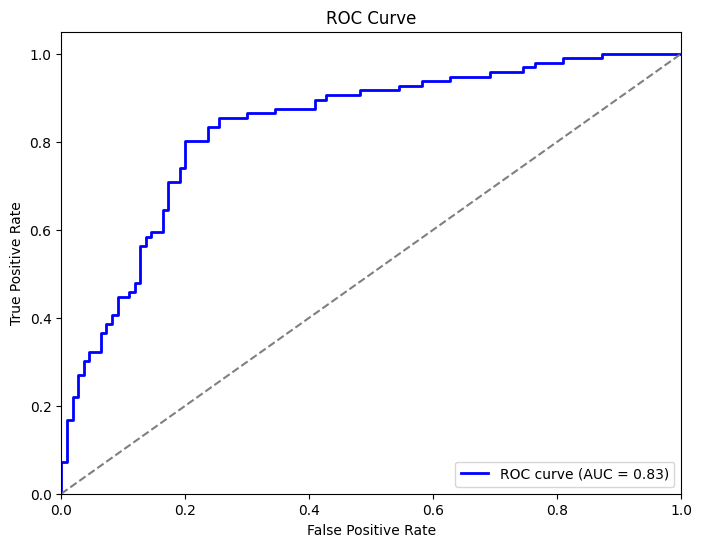

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = nonrecomm_cosines + recomm_cosines

roc_auc = roc_auc_score(labels, y_scores)
fpr, tpr, thresholds = roc_curve(labels, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [22]:
thresholds[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], fpr[np.argmax(tpr - fpr)]

(0.7545507, 0.8020833333333334, 0.2)

In [23]:
tp = 96 * tpr[np.argmax(tpr - fpr)]
fp = np.round(110 * 0.2545454545454545)
fn = 96 - tp
tn = 110 - fp

accuracy = (tp + tn)/(tp + fp + tn + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

accuracy, precision, recall

(0.7718446601941747, 0.7333333333333333, 0.8020833333333334)

In [24]:
fp/sum([fp, tn]), fn/sum([tp, fn])

(0.2545454545454545, 0.19791666666666666)

### Testing

In [25]:
test_embeddings = sbert_model.encode(test_texts)

test_nonrecomm_embeddings = test_embeddings[:15]
test_recomm_embeddings = test_embeddings[15:]

test_recomm_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in test_recomm_embeddings]
test_nonrecomm_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in test_nonrecomm_embeddings]

In [26]:
test_tp = len([cos for cos in test_recomm_cosines if cos >= thresholds[np.argmax(tpr - fpr)]])
test_fn = len([cos for cos in test_recomm_cosines if cos < thresholds[np.argmax(tpr - fpr)]])
test_fp = len([cos for cos in test_nonrecomm_cosines if cos >= thresholds[np.argmax(tpr - fpr)]])
test_tn = len([cos for cos in test_nonrecomm_cosines if cos < thresholds[np.argmax(tpr - fpr)]])

test_accuracy = (test_tp + test_tn)/(test_tp + test_fp + test_fn + test_tn)
test_precision = test_tp / (test_tp + test_fp)
test_recall = test_tp / (test_tp + test_fn)

test_accuracy, test_precision, test_recall

(0.75, 0.6363636363636364, 0.7777777777777778)

In [27]:
test_fp/sum([test_fp, test_tn]), test_fn/sum([test_tp, test_fn])

(0.26666666666666666, 0.2222222222222222)